In [1]:
import pandas as pd
import os

In [2]:
root = r'C:\Users\vatti\OneDrive\Documents\Classes\HAP 880\Week_1'
os.chdir(root)

df = pd.read_csv('highUtilizationPredictionV2wco.csv')

In [3]:
cols = list(df.columns)

cols_remove = ['race', 'patient_id', 'HighUtilizationY2', 'claimCount', 'index']

sel = df[list(set(cols).difference(set(cols_remove)))]

sel_list = sel.columns.tolist()

In [4]:
race = pd.get_dummies(df['race'])

df = pd.concat([df, race], axis = 1)

In [5]:
sz = df.index.size

tr = df[:int(sz * 0.8)]

#tr_size = tr.index.size
#tr_size

ts = df[int(sz * 0.8):]

#ts_size = ts.index.size
#ts_size

##### 1. Random Forest (10-200 trees)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

rf = RandomForestClassifier()

r = []

for n in range(10,200,10):
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(tr[sel_list], tr['HighUtilizationY2'])
    probs = rf.predict_proba(ts[sel_list])[:, 1]
    fpr, tpr, thresholds = roc_curve(ts['HighUtilizationY2'], probs)
    a = auc(fpr,tpr)
    print(a)
    r.append(a)

0.7455420274352682
0.7735638781781123
0.7801319808435799
0.790084001348267
0.7869222204367013
0.792875386044813
0.8004163518792007
0.7954546976912003
0.7981417692407193
0.7991022598558852
0.7992530879520462
0.7981258198645919
0.8019786753752102
0.7998763655088449
0.8034051771707426
0.8023134984659008
0.8023122953529208
0.8023840268997855
0.8006231572455007


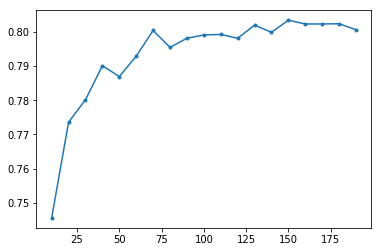

In [8]:
from matplotlib import pyplot as plt

plt.plot (list(range(10, 200, 10)), r, marker = '.')

##### 2. Ranking Features and Selection

In [9]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

chi2 = chi2(tr[sel_list], tr['HighUtilizationY2'])

chi_res = pd.DataFrame()
chi_res['cols'] = sel_list
chi_res['vals'] = chi2[0]

chi_sel = chi_res.sort_values('vals', ascending = False)[:10]
chi_sel

,cols,vals
48,drugs_m11-12,3679.159732
45,drugs_m9-10,3367.922612
51,drugs_m10-11,3253.787491
10,drugs_m7-8,3138.591278
1,drugs_m8-9,3068.603789
30,ELIX6,3009.588921
12,drugs_m6-7,2952.494232
60,drugs_m5-6,2916.070395
22,drugs_m3-4,2773.925780
31,drugs_m4-5,2760.502719


In [10]:
anova = f_classif(tr[sel_list], tr['HighUtilizationY2'])

anova_res = pd.DataFrame()
anova_res ['cols'] = sel_list
anova_res ['vals'] = anova[0]

anova_sel = anova_res.sort_values('vals', ascending = False)[:10]
anova_sel

,cols,vals
30,ELIX6,3786.336686
55,G-22,3497.845277
6,ELIX14,3233.659497
39,G-17,2958.563637
17,G-2,2757.974601
44,ELIX21,2576.242504
16,ELIX13,2238.766990
3,G-11,2012.954224
20,ELIX8,1986.158662
37,G-12,1848.210957


In [10]:
'''
Selecting the top 10 features
'''
anova_features = list(anova_sel['cols'])
anova_features

['ELIX6',
 'G-22',
 'ELIX14',
 'G-17',
 'G-2',
 'ELIX21',
 'ELIX13',
 'G-11',
 'ELIX8',
 'G-12']

###### Random Forest with Selected features

In [11]:
r = []

for i in range (5, 60, 5):
    anova_sel = anova_res.sort_values('vals', ascending = False)['cols'][:i].tolist()
    rf = RandomForestClassifier(n_estimators=200)
    rf.fit(tr[anova_sel], tr['HighUtilizationY2'])
    probs = rf.predict_proba(ts[anova_sel])[:, 1]
    fpr, tpr, thresholds = roc_curve(ts['HighUtilizationY2'], probs)
    a = auc(fpr, tpr)
    print ('i:{} - a:{}'.format(i, a))
    r.append(a)

i:5 - a:0.77148161477532
i:10 - a:0.7894983292012364
i:15 - a:0.7236842935291316
i:20 - a:0.7393651803625688
i:25 - a:0.7594069290333078
i:30 - a:0.7679976434593543
i:35 - a:0.7702005270675383
i:40 - a:0.7794341265403019
i:45 - a:0.7874237234499791
i:50 - a:0.7916187833120035
i:55 - a:0.8003574643763125


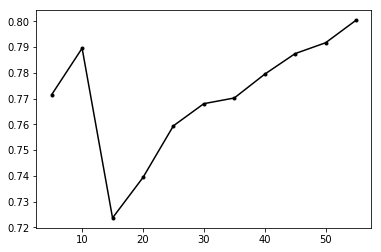

In [12]:
plt.plot (list(range(5, 60, 5)), r, color = 'black', marker = '.')
plt.show()

##### 3. Learning Curves WRT size of data

In [14]:
r = []

for n in range(10,110,10):
    rf = RandomForestClassifier(n_estimators = 200)
    train = tr[: int(sz * n/ 100)]
    print (train.index.size)
    rf.fit(train[sel_list], train['HighUtilizationY2'])
    probs = rf.predict_proba(ts[sel_list])[:, 1]
    fpr, tpr, thresholds = roc_curve(ts['HighUtilizationY2'], probs)
    a = auc(fpr,tpr)
    print(a)
    r.append(a)

11302
0.7976654665668885
22604
0.7984166805566604
33907
0.7953194938054964
45209
0.8021461844702567
56512
0.8015457823183624
67814
0.8028445265220404
79116
0.804096300544646
90419
0.8019740092478418
90419
0.8003118924076221
90419
0.8016546315264895


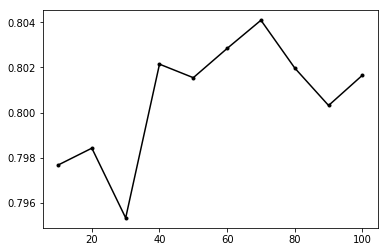

In [18]:
plt.plot (list(range(10, 110, 10)), r, color = 'black', marker = '.')
plt.show()

##### 4. Learning Curves WRT size of data

##### 4a. Random Selection of features for Random Forests, Logistic Regression and Naive bayes

In [16]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

rf = RandomForestClassifier(n_estimators = 200)
lr = LogisticRegression()
nb = GaussianNB()

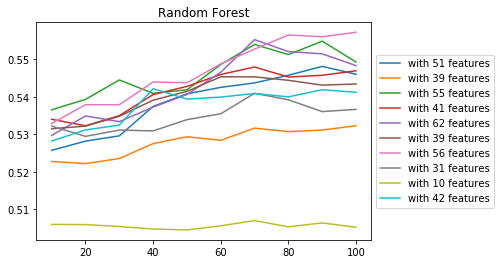

In [17]:
#Random Forest

l_rf = []

for n in range(10):
    
    a_rf = []
    r_rf = []
    tr_sz_rf = []
    
    random.shuffle(sel_list)
    randX_rf = sel_list[:random.randint(10, len(sel_list))]
    le_rf = len(randX_rf)
    l_rf.append(le_rf)
    #print (tr[randX].shape)
    
    for i in range (10, 110, 10):
        train_rf = tr[: int(sz * i/ 100)]
        #print (train[randX].shape)
        rf.fit(train_rf[randX_rf], train_rf['HighUtilizationY2'])
        probs_rf = rf.predict(ts[randX_rf])
        fpr_rf, tpr_rf, thresholds_rf = roc_curve(ts['HighUtilizationY2'], probs_rf)
        a_rf = auc(fpr_rf, tpr_rf)
        #print ('n:{} - i:{} - a:{}'.format(le, i, a))
        r_rf.append(a_rf)
        tr_sz_rf.append(i)   
    
    plt.title("Random Forest")
    plt.plot (tr_sz_rf, r_rf, label = "with {} features".format(le_rf))
    plt.legend()
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

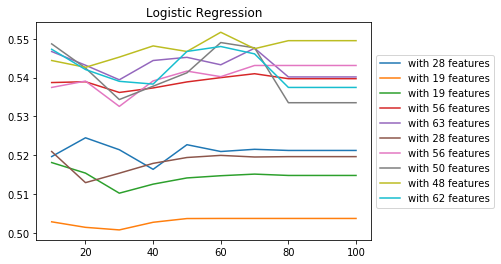

In [19]:
# Logistic Regression

l_lr = []

for n in range(10):
    
    a_lr = []
    r_lr = []
    tr_sz_lr = []
    
    random.shuffle(sel_list)
    randX_lr = sel_list[:random.randint(10, len(sel_list))]
    le_lr = len(randX_lr)
    l_lr.append(le_lr)
    #print (tr[randX].shape)
    
    for i in range (10, 110, 10):
        train_lr = tr[: int(sz * i/ 100)]
        #print (train[randX].shape)
        lr.fit(train_lr[randX_lr], train_lr['HighUtilizationY2'])
        probs_lr = lr.predict(ts[randX_lr])
        fpr_lr, tpr_lr, thresholds_lr = roc_curve(ts['HighUtilizationY2'], probs_lr)
        a_lr = auc(fpr_lr, tpr_lr)
        #print ('n:{} - i:{} - a:{}'.format(le, i, a))
        r_lr.append(a_lr)
        tr_sz_lr.append(i)   
    
    plt.title("Logistic Regression")
    plt.plot (tr_sz_lr, r_lr, label = "with {} features".format(le_lr))
    plt.legend()
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))

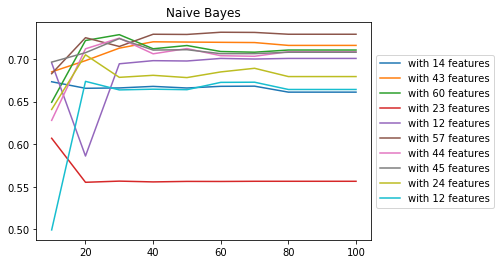

In [20]:
# Naive Bayes

l_nr = []

for n in range(10):
    
    a_nb = []
    r_nb = []
    tr_sz_nb = []
    
    random.shuffle(sel_list)
    randX_nb = sel_list[:random.randint(10, len(sel_list))]
    le_nb = len(randX_nb)
    l_nr.append(le_nb)
    #print (tr[randX].shape)
    
    for i in range (10, 110, 10):
        train_nb = tr[: int(sz * i/ 100)]
        #print (train[randX].shape)
        nb.fit(train_nb[randX_nb], train_nb['HighUtilizationY2'])
        probs_nb = nb.predict(ts[randX_nb])
        fpr_nb, tpr_nb, thresholds_nb = roc_curve(ts['HighUtilizationY2'], probs_nb)
        a_nb = auc(fpr_nb, tpr_nb)
        #print ('n:{} - i:{} - a:{}'.format(le, i, a))
        r_nb.append(a_nb)
        tr_sz_nb.append(i)   
    
    plt.title("Naive Bayes")
    plt.plot (tr_sz_nb, r_nb, label = "with {} features".format(le_nb))
    plt.legend()
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))

##### 4b. Learning Curves WRT selected features

"\n    rf = RandomForestClassifier(n_estimators=200)\n    rf.fit(tr[anova_sel], tr['HighUtilizationY2'])\n    probs = rf.predict_proba(ts[anova_sel])[:, 1]\n    fpr, tpr, thresholds = roc_curve(ts['HighUtilizationY2'], probs)\n    a = auc(fpr, tpr)\n    print ('i:{} - a:{}'.format(i, a))\n    r.append(a)\n"

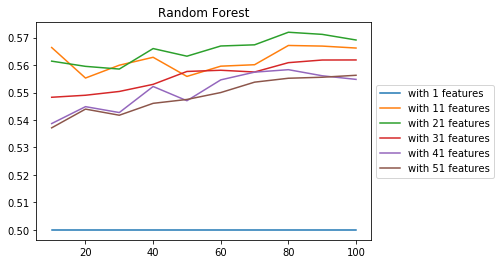

In [25]:
# Random Forest

l_sel_rf = []

for i in range (1, 60, 10):
    
    a_sel_rf = []
    r_sel_rf = []
    tr_sz_sel_rf = []
    
    anova_sel = anova_res.sort_values('vals', ascending = False)['cols'][:i].tolist()
    le_sel_rf = len(anova_sel)
    l_sel_rf.append(le_sel_rf)
    
    for i in range (10, 110, 10):
        
        train_sel_rf = tr[: int(sz * i/100)]
        rf.fit(train_sel_rf[anova_sel], train_sel_rf['HighUtilizationY2'])
        probs_sel_rf = rf.predict(ts[anova_sel])
        fpr_sel_rf, tpr_sel_rf, threshold_sel_rf = roc_curve(ts['HighUtilizationY2'], probs_sel_rf)
        a_sel_rf = auc(fpr_sel_rf, tpr_sel_rf)
        r_sel_rf.append(a_sel_rf)
        tr_sz_sel_rf.append(i)
        
    plt.title("Random Forest")
    plt.plot (tr_sz_sel_rf, r_sel_rf, label = "with {} features". format(le_sel_rf))
    plt.legend()
    plt.legend(loc = 6, bbox_to_anchor = (1, 0.5))  

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

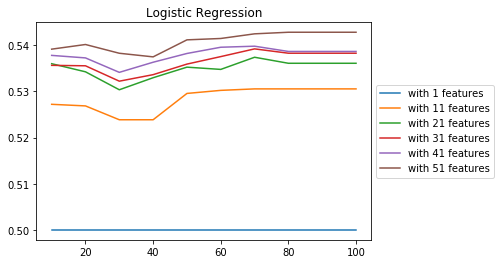

In [29]:
#Logistic Regression

l_sel_lr = []

for i in range(1, 60, 10):
    
    a_sel_lr = []
    r_sel_lr = []
    tr_sz_sel_lr = []
    
    anova_sel = anova_res.sort_values('vals', ascending = False)['cols'][:i].tolist()
    le_sel_lr = len(anova_sel)
    l_sel_lr.append(le_sel_lr)
    
    for i in range (10, 110, 10):
        
        train_sel_lr = tr[: int(sz * i/100)]
        lr.fit(train_sel_lr[anova_sel], train_sel_lr['HighUtilizationY2'])
        probs_sel_lr = lr.predict(ts[anova_sel])
        fpr_sel_lr, tpr_sel_lr, threshold_sel_lr = roc_curve(ts['HighUtilizationY2'], probs_sel_lr)
        a_sel_lr = auc(fpr_sel_lr, tpr_sel_lr)
        r_sel_lr.append(a_sel_lr)
        tr_sz_sel_lr.append(i)
        
    plt.title("Logistic Regression")
    plt.plot (tr_sz_sel_lr, r_sel_lr, label = "with {} features". format(le_sel_lr))
    plt.legend()
    plt.legend(loc = 6, bbox_to_anchor = (1, 0.5))  

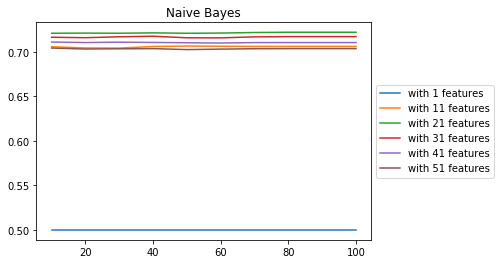

In [31]:
# Naive Bayes

l_sel_nb = []

for i in range(1, 60, 10):
    
    a_sel_nb = []
    r_sel_nb = []
    tr_sz_sel_nb = []
    
    anova_sel = anova_res.sort_values('vals', ascending = False)['cols'][:i].tolist()
    le_sel_nb = len(anova_sel)
    l_sel_nb.append(le_sel_nb)
    
    for i in range (10, 110, 10):
        
        train_sel_nb = tr[: int(sz * i/100)]
        nb.fit(train_sel_nb[anova_sel], train_sel_nb['HighUtilizationY2'])
        probs_sel_nb = nb.predict(ts[anova_sel])
        fpr_sel_nb, tpr_sel_nb, threshold_sel_nb = roc_curve(ts['HighUtilizationY2'], probs_sel_nb)
        a_sel_nb = auc(fpr_sel_nb, tpr_sel_nb)
        r_sel_nb.append(a_sel_nb)
        tr_sz_sel_nb.append(i)
        
    plt.title("Naive Bayes")
    plt.plot (tr_sz_sel_nb, r_sel_nb, label = "with {} features". format(le_sel_nb))
    plt.legend()
    plt.legend(loc = 6, bbox_to_anchor = (1, 0.5))  

##### 5. 3D Plots

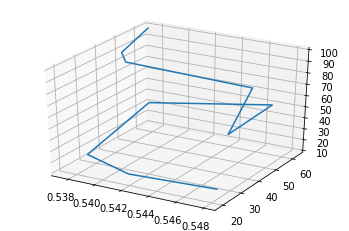

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Logistic Regression

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=l_lr, ys=tr_sz_lr, zs=r_lr, zdir='x')

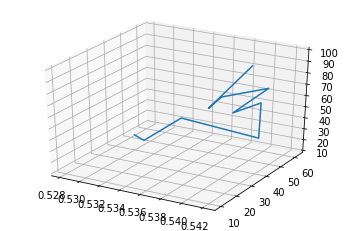

In [22]:
#Random Forest

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=l_rf, ys=tr_sz_rf, zs=r_rf, zdir='x')

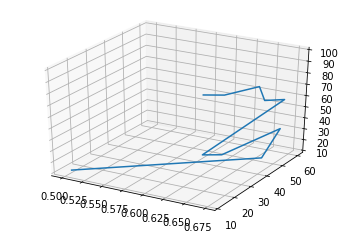

In [23]:
#Naive Bayes

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=l_nr, ys=tr_sz_nb, zs=r_nb, zdir='x')